# Co-DeepNet U-Net: Cooperative Learning for Medical Image Analysis

This notebook implements the Co-DeepNet architecture from "Co-DeepNet: A Cooperative Convolutional Neural Network" paper, adapted for medical image segmentation with tumor classification.

## Key Concepts:
- **Tag-Team Training**: Two U-Nets alternate active training periods
- **Knowledge Transmission**: Active network mentors inactive network
- **Dual Task**: Classification (tumor present?) + Segmentation (where is tumor?)
- **Cooperative Learning**: Networks explore different solution spaces while sharing discoveries

## Architecture Overview:
```
Input → [U-Net-A] ⟷ Knowledge Transfer ⟷ [U-Net-B] → Ensemble → {Classification, Segmentation}
         (active)                          (inactive)
                    ↓ Swap roles ↓
         (inactive)                         (active)
```

## 1. Setup & Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from typing import Tuple

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Modified U-Net - Segmentation

In [2]:
class DoubleConv(nn.Module):
    """(Conv2d → BatchNorm → ReLU) × 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class SegmentationUNet(nn.Module):
    """
    U-Net for segmentation.
    """
    def __init__(self, in_channels=1, seg_classes=1, network_id='A'):
        super().__init__()
        self.network_id = network_id
        
        # Encoder (Contracting Path)
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)
        
        # Decoder (Expanding Path)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        
        # Segmentation Output
        self.seg_out = nn.Conv2d(64, seg_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)
        
        # Segmentation Output (logits)
        seg_logits = self.seg_out(dec1)
        
        return seg_logits
    
    def get_encoder_params(self):
        """Get encoder parameters for knowledge transfer"""
        return list(self.enc1.parameters()) + list(self.enc2.parameters()) + \
               list(self.enc3.parameters()) + list(self.enc4.parameters())
    
    def get_decoder_params(self):
        """Get decoder parameters"""
        return list(self.dec1.parameters()) + list(self.dec2.parameters()) + \
               list(self.dec3.parameters()) + list(self.dec4.parameters())
    
    def get_bottleneck_params(self):
        """Get bottleneck parameters"""
        return list(self.bottleneck.parameters())
    
    def count_parameters(self):
        """Count total trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

## 3. Knowledge Transmission Module

Implements the mentoring mechanism where the active network transfers learned knowledge to the inactive network.

**Transmission Strategies:**
- `encoder_only`: Transfer early feature extractors (like Co-DeepNet paper)
- `full_network`: Transfer all parameters
- `bottleneck_only`: Transfer only the deepest representations

In [3]:
class KnowledgeTransmitter:
    """
    Implements knowledge transmission from active to inactive network.
    
    Based on Co-DeepNet paper: the active network mentors the inactive one,
    allowing the inactive network to benefit from discoveries without training.
    """
    def __init__(self, transmission_rate=0.3, strategy='encoder_only'):
        """
        Args:
            transmission_rate: Weight for knowledge transfer (0.3 = 30% from active, 70% keep own)
            strategy: 'encoder_only', 'full_network', or 'bottleneck_only'
        """
        self.transmission_rate = transmission_rate
        self.strategy = strategy
        self.transmission_count = 0
    
    def transmit(self, active_net: SegmentationUNet, inactive_net: SegmentationUNet):
        """
        Transfer knowledge from active to the inactive network.
        
        Formula: θ_inactive = (1-α) * θ_inactive + α * θ_active
        where α is the transmission_rate
        """
        self.transmission_count += 1
        alpha = self.transmission_rate
        
        # Select parameters based on strategy
        if self.strategy == 'encoder_only':
            active_params = active_net.get_encoder_params()
            inactive_params = inactive_net.get_encoder_params()
        elif self.strategy == 'bottleneck_only':
            active_params = active_net.get_bottleneck_params()
            inactive_params = inactive_net.get_bottleneck_params()
        elif self.strategy == 'full_network':
            active_params = list(active_net.parameters())
            inactive_params = list(inactive_net.parameters())
        else:
            raise ValueError(f"Unknown strategy: {self.strategy}")
        
        # Transfer knowledge with EMA-like update
        with torch.no_grad():
            for inactive_param, active_param in zip(inactive_params, active_params):
                # Inactive retains most of its knowledge but learns from active
                inactive_param.data = (1 - alpha) * inactive_param.data + alpha * active_param.data
        
        return {
            'transmission_id': self.transmission_count,
            'strategy': self.strategy,
            'rate': alpha,
            'params_transferred': len(list(active_params))
        }

## 4. Co-DeepNet Training Manager

Implements the tag-team training strategy:
1. **One network trains** while the other rests
2. **Periodic knowledge transmission** from active to inactive
3. **Role swap** at specified intervals
4. **Ensemble prediction** for final output

In [4]:
class CoDeepNetTrainer:
    """
    Manages cooperative training of two U-Nets following Co-DeepNet principles.
    
    Key mechanisms:
    - Tag-team: Only one network trains at a time
    - Knowledge transmission: Active mentors inactive periodically
    - Role swapping: Networks alternate being active
    - Ensemble: Average both segmentation outputs
    """
    def __init__(
        self,
        unet_a: SegmentationUNet,
        unet_b: SegmentationUNet,
        optimizer_a: torch.optim.Optimizer,
        optimizer_b: torch.optim.Optimizer,
        swap_frequency: int = 50,
        transmission_frequency: int = 10,
        transmission_rate: float = 0.3,
        transmission_strategy: str = 'encoder_only',
        device: str = 'cuda'
    ):
        self.unet_a = unet_a.to(device)
        self.unet_b = unet_b.to(device)
        self.optimizer_a = optimizer_a
        self.optimizer_b = optimizer_b
        
        self.swap_frequency = swap_frequency
        self.transmission_frequency = transmission_frequency
        self.device = device
        
        # Knowledge transmitter
        self.transmitter = KnowledgeTransmitter(
            transmission_rate=transmission_rate,
            strategy=transmission_strategy
        )
        
        # Training state
        self.active_network = 'A'
        self.batch_count = 0
        self.swap_count = 0
        
        # Loss function: BCE
        self.seg_criterion = nn.BCEWithLogitsLoss()
        
        # Metrics tracking
        self.history = {
            'network_a': {'loss': [], 'dice': [], 'iou': []},
            'network_b': {'loss': [], 'dice': [], 'iou': []},
            'active_network': [],
            'transmissions': []
        }
    
    def train_step(self, images: torch.Tensor, seg_masks: torch.Tensor, clf_labels: torch.Tensor):
        """
        Single training step following Co-DeepNet protocol.
        
        NOTE: clf_labels is still passed but not used in loss (only for logging).
        """
        self.batch_count += 1
        images = images.to(self.device)
        seg_masks = seg_masks.to(self.device)
        
        # Determine active network
        if self.active_network == 'A':
            active_net = self.unet_a
            active_optimizer = self.optimizer_a
            inactive_net = self.unet_b
            net_key = 'network_a'
        else:
            active_net = self.unet_b
            active_optimizer = self.optimizer_b
            inactive_net = self.unet_a
            net_key = 'network_b'
        
        # Train ONLY active network (tag-team principle)
        active_net.train()
        inactive_net.eval()
        
        active_optimizer.zero_grad()
        
        # Forward pass (active network only)
        seg_logits = active_net(images)
        
        # Compute ONLY segmentation loss
        loss = self.seg_criterion(seg_logits, seg_masks)
        
        # Backward pass
        loss.backward()
        active_optimizer.step()
        
        # Compute metrics for monitoring
        with torch.no_grad():
            seg_probs = torch.sigmoid(seg_logits)
            dice = self._compute_dice(seg_probs, seg_masks)
            iou = self._compute_iou(seg_probs, seg_masks)
        
        # Knowledge transmission (periodic mentoring)
        transmission_info = None
        if self.batch_count % self.transmission_frequency == 0:
            transmission_info = self.transmitter.transmit(active_net, inactive_net)
            self.history['transmissions'].append({
                'batch': self.batch_count,
                'from': self.active_network,
                'info': transmission_info
            })
        
        # Role swap (tag-team rotation)
        swapped = False
        if self.batch_count % self.swap_frequency == 0:
            self.active_network = 'B' if self.active_network == 'A' else 'A'
            self.swap_count += 1
            swapped = True
        
        # Record metrics
        self.history[net_key]['loss'].append(loss.item())
        self.history[net_key]['dice'].append(dice)
        self.history[net_key]['iou'].append(iou)
        self.history['active_network'].append(self.active_network)
        
        return {
            'loss': loss.item(),
            'dice': dice,
            'iou': iou,
            'active_network': self.active_network,
            'swapped': swapped,
            'transmission': transmission_info is not None
        }
    
    def _compute_dice(self, pred, target, threshold=0.5, epsilon=1e-7):
        """Compute Dice coefficient"""
        pred_binary = (pred > threshold).float()
        target_binary = (target > threshold).float()
        
        intersection = (pred_binary * target_binary).sum()
        union = pred_binary.sum() + target_binary.sum()
        
        dice = (2.0 * intersection) / (union + epsilon)
        return dice.item()
    
    def _compute_iou(self, pred, target, threshold=0.5, epsilon=1e-7):
        """Compute IoU"""
        pred_binary = (pred > threshold).float()
        target_binary = (target > threshold).float()
        
        intersection = (pred_binary * target_binary).sum()
        union = pred_binary.sum() + target_binary.sum() - intersection
        
        iou = intersection / (union + epsilon)
        return iou.item()
    
    def predict_ensemble(self, images: torch.Tensor):
        """
        Ensemble prediction: Average segmentation outputs from both networks.
        """
        self.unet_a.eval()
        self.unet_b.eval()
        
        with torch.no_grad():
            images = images.to(self.device)
            
            # Get predictions from both networks
            seg_a = self.unet_a(images)
            seg_b = self.unet_b(images)
            
            # Ensemble: Average logits
            seg_ensemble = (seg_a + seg_b) / 2
            
            # Apply sigmoid for probabilities
            seg_probs = torch.sigmoid(seg_ensemble)
            seg_probs_a = torch.sigmoid(seg_a)
            seg_probs_b = torch.sigmoid(seg_b)
        
        return seg_probs, seg_probs_a, seg_probs_b
    
    def get_training_summary(self):
        """Get summary of training dynamics"""
        return {
            'total_batches': self.batch_count,
            'total_swaps': self.swap_count,
            'total_transmissions': self.transmitter.transmission_count,
            'final_active': self.active_network,
            'avg_loss_a': np.mean(self.history['network_a']['loss'][-100:]) if self.history['network_a']['loss'] else 0,
            'avg_loss_b': np.mean(self.history['network_b']['loss'][-100:]) if self.history['network_b']['loss'] else 0
        }

## 5. Dataset & DataLoader

## 5b. Load Pre-Split Dataset 🎯

### ✅ Using Pre-Split Preprocessed Data

The data has been split by the EDA notebook into train/val/test:
- **Train**: 127 patients + 298 controls = 425 samples
- **Val**: 27 patients + 64 controls = 91 samples  
- **Test**: 28 patients + 64 controls = 92 samples

The preprocessed data structure:
```
preprocessed_data/
├── train/
│   ├── controls/imgs/
│   └── patients/
│       ├── imgs/
│       └── labels/
├── val/
│   ├── controls/imgs/
│   └── patients/
│       ├── imgs/
│       └── labels/
└── test/
    ├── controls/imgs/
    └── patients/
        ├── imgs/
        └── labels/
```

No splitting needed - just load from the correct directory!

In [5]:
from PIL import Image

class PreSplitTumorDataset(Dataset):
    """Dataset for loading pre-split train/val/test data"""
    def __init__(self, data_dir: str, split='train'):
        """
        Args:
            data_dir: Path to preprocessed_data directory
            split: 'train', 'val', or 'test'
        """
        self.data_dir = Path(data_dir) / split
        self.split = split
        
        print(f"\n{'='*70}")
        print(f"📂 Loading {split.upper()} dataset from: {self.data_dir}")
        print(f"{'='*70}")
        
        if not self.data_dir.exists():
            raise FileNotFoundError(f"Split directory not found: {self.data_dir}")
        
        self.samples = []
        
        control_dir = self.data_dir / 'controls' / 'imgs'
        patient_img_dir = self.data_dir / 'patients' / 'imgs'
        patient_label_dir = self.data_dir / 'patients' / 'labels'
        
        print(f"  Controls dir: {control_dir.exists()}")
        print(f"  Patients dir: {patient_img_dir.exists()}")
        print(f"  Labels dir: {patient_label_dir.exists()}")
        
        if control_dir.exists():
            control_files = sorted(list(control_dir.glob('*.png')))
            print(f"\n  Found {len(control_files)} control images")
            for img_path in control_files:
                self.samples.append((img_path, None, 0))
        
        if patient_img_dir.exists() and patient_label_dir.exists():
            patient_files = sorted(list(patient_img_dir.glob('*.png')))
            print(f"  Found {len(patient_files)} patient images")
            
            matched = 0
            for img_path in patient_files:
                img_stem = img_path.stem
                
                possible_label_names = [
                    img_path.name,
                    img_stem + '.png',
                    img_stem.replace('patient_', 'segmentation_') + '.png',
                ]
                
                label_path = None
                for label_name in possible_label_names:
                    test_path = patient_label_dir / label_name
                    if test_path.exists():
                        label_path = test_path
                        break
                
                if label_path:
                    self.samples.append((img_path, label_path, 1))
                    matched += 1
            
            print(f"  Matched {matched} patient images with labels")
        
        num_controls = len([s for s in self.samples if s[2] == 0])
        num_patients = len([s for s in self.samples if s[2] == 1])
        
        print(f"\n{'='*70}")
        print(f"📊 {split.upper()} SET SUMMARY")
        print(f"{'='*70}")
        print(f"  Controls: {num_controls}")
        print(f"  Patients: {num_patients}")
        print(f"  Total: {len(self.samples)}")
        print(f"  Tumor ratio: {num_patients/len(self.samples)*100:.1f}%")
        print(f"{'='*70}\n")
        
        if len(self.samples) == 0:
            raise ValueError(f"No samples found in {self.data_dir}")
    
    def __len__(self):
        return len(self.samples)
    
    def _load_image(self, path: Path) -> np.ndarray:
        """Load PNG image and convert to grayscale numpy array"""
        img = Image.open(path).convert('L')
        return np.array(img)
    
    def __getitem__(self, idx):
        img_path, label_path, has_tumor = self.samples[idx]
        
        image = self._load_image(img_path)
        
        if image.max() > 1.0:
            image = image / 255.0
        
        if label_path and label_path.exists():
            mask = self._load_image(label_path)
            if mask.max() > 1.0:
                mask = mask / 255.0
        else:
            mask = np.zeros_like(image)
        
        if image.ndim == 2:
            image = image[np.newaxis, ...]
        if mask.ndim == 2:
            mask = mask[np.newaxis, ...]
        
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).float()
        clf_label = torch.tensor(has_tumor, dtype=torch.long)
        
        return image, mask, clf_label


print("="*70)
print("🔍 LOADING PRE-SPLIT MIP-PET TUMOR DATASET")
print("="*70)

possible_paths = [
    Path('/Users/idahayjorgensen/Documents/cs/deep_learning/DeepLearning-MiniProject/preprocessed_data'),
    Path('/work/IdaHayJørgensen#9284/Notebooks/preprocessed_data'),
]

DATA_DIR = None
for path in possible_paths:
    print(f"\n🔍 Checking: {path}")
    if path.exists():
        has_train = (path / 'train').exists()
        has_val = (path / 'val').exists()
        has_test = (path / 'test').exists()
        
        print(f"   Train folder: {has_train}")
        print(f"   Val folder: {has_val}")
        print(f"   Test folder: {has_test}")
        
        if has_train and has_val and has_test:
            DATA_DIR = path
            print(f"   ✅ Using this directory!")
            break
    else:
        print(f"   ❌ Directory doesn't exist")

if DATA_DIR is None:
    raise FileNotFoundError("Pre-split data directory not found! Please run EDA.ipynb first to create splits.")

print(f"\n{'='*70}")
print(f"📂 Final data directory: {DATA_DIR}")
print(f"{'='*70}\n")

train_dataset = PreSplitTumorDataset(str(DATA_DIR), split='train')
val_dataset = PreSplitTumorDataset(str(DATA_DIR), split='val')
test_dataset = PreSplitTumorDataset(str(DATA_DIR), split='test')

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\n{'='*70}")
print(f"✅ DATALOADERS CREATED")
print(f"{'='*70}")
print(f"  Train batches: {len(train_loader)} ({len(train_dataset)} samples)")
print(f"  Val batches: {len(val_loader)} ({len(val_dataset)} samples)")
print(f"  Test batches: {len(test_loader)} ({len(test_dataset)} samples)")
print(f"{'='*70}\n")

first_batch = next(iter(train_loader))
images, masks, labels = first_batch
print(f"📊 First batch statistics:")
print(f"  Image shape: {images.shape}")
print(f"  Mask shape: {masks.shape}")
print(f"  Labels: {labels.tolist()} (0=no tumor, 1=tumor)")
print(f"  Tumors in batch: {labels.sum().item()}/{len(labels)}")


🔍 LOADING PRE-SPLIT MIP-PET TUMOR DATASET

🔍 Checking: /Users/idahayjorgensen/Documents/cs/deep_learning/DeepLearning-MiniProject/preprocessed_data
   ❌ Directory doesn't exist

🔍 Checking: /work/IdaHayJørgensen#9284/Notebooks/preprocessed_data
   Train folder: True
   Val folder: True
   Test folder: True
   ✅ Using this directory!

📂 Final data directory: /work/IdaHayJørgensen#9284/Notebooks/preprocessed_data


📂 Loading TRAIN dataset from: /work/IdaHayJørgensen#9284/Notebooks/preprocessed_data/train
  Controls dir: True
  Patients dir: True
  Labels dir: True

  Found 298 control images
  Found 127 patient images
  Matched 127 patient images with labels

📊 TRAIN SET SUMMARY
  Controls: 298
  Patients: 127
  Total: 425
  Tumor ratio: 29.9%


📂 Loading VAL dataset from: /work/IdaHayJørgensen#9284/Notebooks/preprocessed_data/val
  Controls dir: True
  Patients dir: True
  Labels dir: True

  Found 64 control images
  Found 27 patient images
  Matched 27 patient images with labels

📊 VA

## 6. Initialize Co-DeepNet System

In [6]:
# Initialize two segmentation U-Nets with different random initializations
set_seed(42)
unet_a = SegmentationUNet(in_channels=1, seg_classes=1, network_id='A')

set_seed(123)  # Different seed for diversity
unet_b = SegmentationUNet(in_channels=1, seg_classes=1, network_id='B')

# Separate optimizers for each network
optimizer_a = torch.optim.Adam(unet_a.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer_b = torch.optim.Adam(unet_b.parameters(), lr=1e-4, weight_decay=1e-5)

# Initialize Co-DeepNet trainer
codeepnet_trainer = CoDeepNetTrainer(
    unet_a=unet_a,
    unet_b=unet_b,
    optimizer_a=optimizer_a,
    optimizer_b=optimizer_b,
    swap_frequency=50,
    transmission_frequency=10,
    transmission_rate=0.3,
    transmission_strategy='encoder_only',
    device=device
)

print("\n✓ Co-DeepNet initialized:")
print(f"  Network A parameters: {unet_a.count_parameters():,}")
print(f"  Network B parameters: {unet_b.count_parameters():,}")
print(f"  Tag-team frequency: {codeepnet_trainer.swap_frequency} batches")
print(f"  Knowledge transmission: every {codeepnet_trainer.transmission_frequency} batches")
print(f"  Transmission rate: {codeepnet_trainer.transmitter.transmission_rate}")
print(f"  Strategy: {codeepnet_trainer.transmitter.strategy}")


✓ Co-DeepNet initialized:
  Network A parameters: 31,042,369
  Network B parameters: 31,042,369
  Tag-team frequency: 50 batches
  Knowledge transmission: every 10 batches
  Transmission rate: 0.3
  Strategy: encoder_only


## 7. Training Loop

In [7]:
import time

def train_epoch(trainer, dataloader, epoch):
    """Train for one epoch using Co-DeepNet protocol"""
    epoch_metrics = {
        'loss': [],
        'dice': [],
        'iou': [],
        'swaps': 0,
        'transmissions': 0
    }
    
    pbar = tqdm(dataloader, desc=f"Epoch {epoch} [Train]")
    for images, masks, clf_labels in pbar:
        metrics = trainer.train_step(images, masks, clf_labels)
        
        epoch_metrics['loss'].append(metrics['loss'])
        epoch_metrics['dice'].append(metrics['dice'])
        epoch_metrics['iou'].append(metrics['iou'])
        if metrics['swapped']:
            epoch_metrics['swaps'] += 1
        if metrics['transmission']:
            epoch_metrics['transmissions'] += 1
        
        pbar.set_postfix({
            'loss': f"{metrics['loss']:.4f}",
            'dice': f"{metrics['dice']:.4f}",
            'active': metrics['active_network']
        })
    
    return {
        'avg_loss': np.mean(epoch_metrics['loss']),
        'avg_dice': np.mean(epoch_metrics['dice']),
        'avg_iou': np.mean(epoch_metrics['iou']),
        'swaps': epoch_metrics['swaps'],
        'transmissions': epoch_metrics['transmissions']
    }


def validate_epoch(trainer, dataloader, epoch):
    """Validate for one epoch"""
    trainer.unet_a.eval()
    trainer.unet_b.eval()
    
    epoch_metrics = {
        'loss': [],
        'dice': [],
        'iou': []
    }
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc=f"Epoch {epoch} [Val]")
        for images, masks, _ in pbar:
            images = images.to(trainer.device)
            masks = masks.to(trainer.device)
            
            # Ensemble prediction
            seg_probs, _, _ = trainer.predict_ensemble(images)
            
            # Compute metrics
            epsilon = 1e-7
            loss = F.binary_cross_entropy(seg_probs.clamp(epsilon, 1-epsilon), masks)
            dice = trainer._compute_dice(seg_probs, masks)
            iou = trainer._compute_iou(seg_probs, masks)
            
            epoch_metrics['loss'].append(loss.item())
            epoch_metrics['dice'].append(dice)
            epoch_metrics['iou'].append(iou)
            
            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'dice': f"{dice:.4f}"
            })
    
    return {
        'avg_loss': np.mean(epoch_metrics['loss']),
        'avg_dice': np.mean(epoch_metrics['dice']),
        'avg_iou': np.mean(epoch_metrics['iou'])
    }


# Training configuration
NUM_EPOCHS = 50
training_history = {
    'train_loss': [], 'train_dice': [], 'train_iou': [],
    'val_loss': [], 'val_dice': [], 'val_iou': [],
    'epoch_times': []
}

print("\n" + "="*70)
print("🚀 STARTING CO-DEEPNET TRAINING (Segmentation-Only)")
print("="*70)
print("Protocol: Tag-team + Knowledge transmission + Role swapping")
print(f"Epochs: {NUM_EPOCHS}\n")

training_start = time.time()
best_val_dice = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start = time.time()
    
    # Train
    train_metrics = train_epoch(codeepnet_trainer, train_loader, epoch)
    
    # Validate
    val_metrics = validate_epoch(codeepnet_trainer, val_loader, epoch)
    
    # Track history
    training_history['train_loss'].append(train_metrics['avg_loss'])
    training_history['train_dice'].append(train_metrics['avg_dice'])
    training_history['train_iou'].append(train_metrics['avg_iou'])
    training_history['val_loss'].append(val_metrics['avg_loss'])
    training_history['val_dice'].append(val_metrics['avg_dice'])
    training_history['val_iou'].append(val_metrics['avg_iou'])
    
    epoch_time = time.time() - epoch_start
    training_history['epoch_times'].append(epoch_time)
    
    # Print summary
    print(f"\nEpoch {epoch}/{NUM_EPOCHS} Summary:")
    print(f"  Train - Loss: {train_metrics['avg_loss']:.4f}, Dice: {train_metrics['avg_dice']:.4f}, IoU: {train_metrics['avg_iou']:.4f}")
    print(f"  Val   - Loss: {val_metrics['avg_loss']:.4f}, Dice: {val_metrics['avg_dice']:.4f}, IoU: {val_metrics['avg_iou']:.4f}")
    print(f"  Swaps: {train_metrics['swaps']}, Transmissions: {train_metrics['transmissions']}")
    print(f"  Time: {epoch_time:.1f}s")
    
    # Save best model
    if val_metrics['avg_dice'] > best_val_dice:
        best_val_dice = val_metrics['avg_dice']
        torch.save({
            'unet_a': codeepnet_trainer.unet_a.state_dict(),
            'unet_b': codeepnet_trainer.unet_b.state_dict(),
            'epoch': epoch,
            'val_dice': best_val_dice
        }, 'best_codeepnet_segmentation.pth')
        print(f"  ✓ New best model saved! (Val Dice: {best_val_dice:.4f})")

training_time = time.time() - training_start

# Training summary
summary = codeepnet_trainer.get_training_summary()
print("\n" + "="*70)
print("🎓 TRAINING COMPLETE!")
print("="*70)
print(f"Total training time: {training_time:.1f}s ({training_time/60:.1f} minutes)")
print(f"Average epoch time: {np.mean(training_history['epoch_times']):.1f}s")
print(f"Best validation Dice: {best_val_dice:.4f}")
print(f"Total batches: {summary[    'total_batches']}")
print(f"Total swaps: {summary['total_swaps']}")
print(f"Total transmissions: {summary['total_transmissions']}")

# Load best model
checkpoint = torch.load('best_codeepnet_segmentation.pth', weights_only=False)
codeepnet_trainer.unet_a.load_state_dict(checkpoint['unet_a'])
codeepnet_trainer.unet_b.load_state_dict(checkpoint['unet_b'])
print("\n✓ Best model loaded for evaluation!")


🚀 STARTING CO-DEEPNET TRAINING (Segmentation-Only)
Protocol: Tag-team + Knowledge transmission + Role swapping
Epochs: 50



Epoch 1 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.93it/s, loss=0.5624, dice=0.0196]



Epoch 1/50 Summary:
  Train - Loss: 0.5469, Dice: 0.0379, IoU: 0.0198
  Val   - Loss: 0.5592, Dice: 0.0029, IoU: 0.0015
  Swaps: 1, Transmissions: 5
  Time: 14.9s
  ✓ New best model saved! (Val Dice: 0.0029)


Epoch 2 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.94it/s, loss=0.5678, dice=0.1285]



Epoch 2/50 Summary:
  Train - Loss: 0.4740, Dice: 0.0456, IoU: 0.0245
  Val   - Loss: 0.5804, Dice: 0.0481, IoU: 0.0261
  Swaps: 1, Transmissions: 5
  Time: 14.6s
  ✓ New best model saved! (Val Dice: 0.0481)


Epoch 3 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.93it/s, loss=0.4610, dice=0.1913]



Epoch 3/50 Summary:
  Train - Loss: 0.3857, Dice: 0.0316, IoU: 0.0188
  Val   - Loss: 0.5099, Dice: 0.0627, IoU: 0.0349
  Swaps: 1, Transmissions: 6
  Time: 14.8s
  ✓ New best model saved! (Val Dice: 0.0627)


Epoch 4 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.67it/s, loss=0.3397, dice=0.0000]



Epoch 4/50 Summary:
  Train - Loss: 0.3567, Dice: 0.0619, IoU: 0.0346
  Val   - Loss: 0.3387, Dice: 0.0026, IoU: 0.0013
  Swaps: 1, Transmissions: 5
  Time: 14.9s


Epoch 5 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.98it/s, loss=0.3197, dice=0.0000]



Epoch 5/50 Summary:
  Train - Loss: 0.3345, Dice: 0.0300, IoU: 0.0173
  Val   - Loss: 0.3152, Dice: 0.0000, IoU: 0.0000
  Swaps: 1, Transmissions: 6
  Time: 14.7s


Epoch 6 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.96it/s, loss=0.3064, dice=0.0000]



Epoch 6/50 Summary:
  Train - Loss: 0.3114, Dice: 0.0276, IoU: 0.0155
  Val   - Loss: 0.3113, Dice: 0.0338, IoU: 0.0189
  Swaps: 1, Transmissions: 5
  Time: 14.7s


Epoch 7 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.88it/s, loss=0.2922, dice=0.0000]



Epoch 7/50 Summary:
  Train - Loss: 0.2963, Dice: 0.0147, IoU: 0.0081
  Val   - Loss: 0.2856, Dice: 0.0000, IoU: 0.0000
  Swaps: 1, Transmissions: 5
  Time: 14.7s


Epoch 8 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.95it/s, loss=0.2911, dice=0.0114]



Epoch 8/50 Summary:
  Train - Loss: 0.2858, Dice: 0.0083, IoU: 0.0044
  Val   - Loss: 0.2771, Dice: 0.0107, IoU: 0.0055
  Swaps: 1, Transmissions: 6
  Time: 14.7s


Epoch 9 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.75it/s, loss=0.2694, dice=0.0000]



Epoch 9/50 Summary:
  Train - Loss: 0.2716, Dice: 0.0153, IoU: 0.0086
  Val   - Loss: 0.2666, Dice: 0.0109, IoU: 0.0057
  Swaps: 1, Transmissions: 5
  Time: 15.0s


Epoch 10 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.87it/s, loss=0.2618, dice=0.0000]



Epoch 10/50 Summary:
  Train - Loss: 0.2657, Dice: 0.0090, IoU: 0.0047
  Val   - Loss: 0.2551, Dice: 0.0000, IoU: 0.0000
  Swaps: 1, Transmissions: 6
  Time: 15.9s


Epoch 11 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.64it/s, loss=0.2494, dice=0.0000]



Epoch 11/50 Summary:
  Train - Loss: 0.2471, Dice: 0.0059, IoU: 0.0032
  Val   - Loss: 0.2412, Dice: 0.0000, IoU: 0.0000
  Swaps: 1, Transmissions: 5
  Time: 14.8s


Epoch 12 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.95it/s, loss=0.2366, dice=0.0000]



Epoch 12/50 Summary:
  Train - Loss: 0.2474, Dice: 0.0180, IoU: 0.0104
  Val   - Loss: 0.2310, Dice: 0.0157, IoU: 0.0082
  Swaps: 1, Transmissions: 5
  Time: 14.7s


Epoch 13 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.77it/s, loss=0.2316, dice=0.0977]



Epoch 13/50 Summary:
  Train - Loss: 0.2209, Dice: 0.0054, IoU: 0.0028
  Val   - Loss: 0.2372, Dice: 0.0513, IoU: 0.0283
  Swaps: 2, Transmissions: 6
  Time: 14.7s


Epoch 14 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.88it/s, loss=0.2186, dice=0.0000]



Epoch 14/50 Summary:
  Train - Loss: 0.2243, Dice: 0.0061, IoU: 0.0032
  Val   - Loss: 0.2097, Dice: 0.0000, IoU: 0.0000
  Swaps: 1, Transmissions: 5
  Time: 14.6s


Epoch 15 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.95it/s, loss=0.2087, dice=0.0000]



Epoch 15/50 Summary:
  Train - Loss: 0.2049, Dice: 0.0023, IoU: 0.0012
  Val   - Loss: 0.2022, Dice: 0.0005, IoU: 0.0002
  Swaps: 1, Transmissions: 6
  Time: 15.0s


Epoch 16 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.48it/s, loss=0.2030, dice=0.0000]



Epoch 16/50 Summary:
  Train - Loss: 0.2055, Dice: 0.0051, IoU: 0.0027
  Val   - Loss: 0.1945, Dice: 0.0000, IoU: 0.0000
  Swaps: 1, Transmissions: 5
  Time: 15.0s


Epoch 17 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.87it/s, loss=0.1944, dice=0.0000]



Epoch 17/50 Summary:
  Train - Loss: 0.1912, Dice: 0.0065, IoU: 0.0035
  Val   - Loss: 0.1849, Dice: 0.0000, IoU: 0.0000
  Swaps: 1, Transmissions: 5
  Time: 14.7s


Epoch 18 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.92it/s, loss=0.1878, dice=0.0000]



Epoch 18/50 Summary:
  Train - Loss: 0.1867, Dice: 0.0013, IoU: 0.0006
  Val   - Loss: 0.1782, Dice: 0.0000, IoU: 0.0000
  Swaps: 1, Transmissions: 6
  Time: 14.7s


Epoch 19 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.92it/s, loss=0.1789, dice=0.0000]



Epoch 19/50 Summary:
  Train - Loss: 0.1781, Dice: 0.0045, IoU: 0.0023
  Val   - Loss: 0.1731, Dice: 0.0108, IoU: 0.0056
  Swaps: 1, Transmissions: 5
  Time: 14.6s


Epoch 20 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.98it/s, loss=0.1814, dice=0.0000]



Epoch 20/50 Summary:
  Train - Loss: 0.1714, Dice: 0.0015, IoU: 0.0008
  Val   - Loss: 0.1714, Dice: 0.0000, IoU: 0.0000
  Swaps: 1, Transmissions: 6
  Time: 14.6s


Epoch 21 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.97it/s, loss=0.1705, dice=0.0000]



Epoch 21/50 Summary:
  Train - Loss: 0.1673, Dice: 0.0000, IoU: 0.0000
  Val   - Loss: 0.1608, Dice: 0.0000, IoU: 0.0000
  Swaps: 1, Transmissions: 5
  Time: 14.6s


Epoch 22 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.93it/s, loss=0.1609, dice=0.0000]



Epoch 22/50 Summary:
  Train - Loss: 0.1561, Dice: 0.0027, IoU: 0.0014
  Val   - Loss: 0.1513, Dice: 0.0000, IoU: 0.0000
  Swaps: 1, Transmissions: 5
  Time: 14.7s


Epoch 23 [Val]: 100%|██████████| 12/12 [00:01<00:00,  7.02it/s, loss=0.1565, dice=0.0000]



Epoch 23/50 Summary:
  Train - Loss: 0.1547, Dice: 0.0019, IoU: 0.0010
  Val   - Loss: 0.1462, Dice: 0.0000, IoU: 0.0000
  Swaps: 1, Transmissions: 6
  Time: 14.6s


Epoch 24 [Val]: 100%|██████████| 12/12 [00:01<00:00,  7.03it/s, loss=0.1526, dice=0.0000]



Epoch 24/50 Summary:
  Train - Loss: 0.1431, Dice: 0.0002, IoU: 0.0001
  Val   - Loss: 0.1408, Dice: 0.0000, IoU: 0.0000
  Swaps: 1, Transmissions: 5
  Time: 14.5s


Epoch 25 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.62it/s, loss=0.1458, dice=0.0000]



Epoch 25/50 Summary:
  Train - Loss: 0.1454, Dice: 0.0003, IoU: 0.0001
  Val   - Loss: 0.1342, Dice: 0.0000, IoU: 0.0000
  Swaps: 2, Transmissions: 6
  Time: 14.6s


Epoch 26 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.62it/s, loss=0.1674, dice=0.1559]



Epoch 26/50 Summary:
  Train - Loss: 0.1322, Dice: 0.0010, IoU: 0.0005
  Val   - Loss: 0.1692, Dice: 0.0638, IoU: 0.0359
  Swaps: 1, Transmissions: 5
  Time: 15.0s
  ✓ New best model saved! (Val Dice: 0.0638)


Epoch 27 [Val]: 100%|██████████| 12/12 [00:01<00:00,  7.02it/s, loss=0.1382, dice=0.0000]



Epoch 27/50 Summary:
  Train - Loss: 0.1347, Dice: 0.0034, IoU: 0.0018
  Val   - Loss: 0.1272, Dice: 0.0000, IoU: 0.0000
  Swaps: 1, Transmissions: 5
  Time: 14.6s


Epoch 28 [Val]: 100%|██████████| 12/12 [00:01<00:00,  7.06it/s, loss=0.1308, dice=0.0000]



Epoch 28/50 Summary:
  Train - Loss: 0.1247, Dice: 0.0002, IoU: 0.0001
  Val   - Loss: 0.1196, Dice: 0.0000, IoU: 0.0000
  Swaps: 1, Transmissions: 6
  Time: 14.5s


Epoch 29 [Val]: 100%|██████████| 12/12 [00:01<00:00,  7.00it/s, loss=0.1304, dice=0.0000]



Epoch 29/50 Summary:
  Train - Loss: 0.1239, Dice: 0.0031, IoU: 0.0017
  Val   - Loss: 0.1200, Dice: 0.0000, IoU: 0.0000
  Swaps: 1, Transmissions: 5
  Time: 14.7s


Epoch 30 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.60it/s, loss=0.1240, dice=0.0000]



Epoch 30/50 Summary:
  Train - Loss: 0.1171, Dice: 0.0034, IoU: 0.0017
  Val   - Loss: 0.1140, Dice: 0.0000, IoU: 0.0000
  Swaps: 1, Transmissions: 6
  Time: 15.0s


Epoch 31 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.84it/s, loss=0.1224, dice=0.0000]



Epoch 31/50 Summary:
  Train - Loss: 0.1140, Dice: 0.0056, IoU: 0.0030
  Val   - Loss: 0.1107, Dice: 0.0000, IoU: 0.0000
  Swaps: 1, Transmissions: 5
  Time: 15.7s


Epoch 32 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.93it/s, loss=0.1184, dice=0.0000]



Epoch 32/50 Summary:
  Train - Loss: 0.1101, Dice: 0.0130, IoU: 0.0074
  Val   - Loss: 0.1094, Dice: 0.0000, IoU: 0.0000
  Swaps: 1, Transmissions: 5
  Time: 14.6s


Epoch 33 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.50it/s, loss=0.1185, dice=0.0000]



Epoch 33/50 Summary:
  Train - Loss: 0.1054, Dice: 0.0029, IoU: 0.0015
  Val   - Loss: 0.1071, Dice: 0.0000, IoU: 0.0000
  Swaps: 1, Transmissions: 6
  Time: 14.9s


Epoch 34 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.87it/s, loss=0.1135, dice=0.0000]



Epoch 34/50 Summary:
  Train - Loss: 0.1036, Dice: 0.0394, IoU: 0.0230
  Val   - Loss: 0.1029, Dice: 0.0007, IoU: 0.0004
  Swaps: 1, Transmissions: 5
  Time: 14.8s


Epoch 35 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.07it/s, loss=0.1112, dice=0.0000]



Epoch 35/50 Summary:
  Train - Loss: 0.0979, Dice: 0.0035, IoU: 0.0018
  Val   - Loss: 0.1010, Dice: 0.0000, IoU: 0.0000
  Swaps: 1, Transmissions: 6
  Time: 14.8s


Epoch 36 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.64it/s, loss=0.1062, dice=0.1038]



Epoch 36/50 Summary:
  Train - Loss: 0.0975, Dice: 0.0901, IoU: 0.0555
  Val   - Loss: 0.0965, Dice: 0.0364, IoU: 0.0197
  Swaps: 1, Transmissions: 5
  Time: 16.0s


Epoch 37 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.96it/s, loss=0.1011, dice=0.0319]



Epoch 37/50 Summary:
  Train - Loss: 0.0900, Dice: 0.0216, IoU: 0.0129
  Val   - Loss: 0.0899, Dice: 0.0043, IoU: 0.0022
  Swaps: 1, Transmissions: 5
  Time: 14.7s


Epoch 38 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.98it/s, loss=0.0953, dice=0.0955]



Epoch 38/50 Summary:
  Train - Loss: 0.0919, Dice: 0.1437, IoU: 0.0865
  Val   - Loss: 0.0845, Dice: 0.0295, IoU: 0.0158
  Swaps: 2, Transmissions: 6
  Time: 14.8s


Epoch 39 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.92it/s, loss=0.0967, dice=0.0211]



Epoch 39/50 Summary:
  Train - Loss: 0.0842, Dice: 0.0122, IoU: 0.0065
  Val   - Loss: 0.0848, Dice: 0.0060, IoU: 0.0031
  Swaps: 1, Transmissions: 5
  Time: 14.8s


Epoch 40 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.99it/s, loss=0.0943, dice=0.2636]



Epoch 40/50 Summary:
  Train - Loss: 0.0850, Dice: 0.1833, IoU: 0.1154
  Val   - Loss: 0.0827, Dice: 0.1048, IoU: 0.0646
  Swaps: 1, Transmissions: 6
  Time: 14.5s
  ✓ New best model saved! (Val Dice: 0.1048)


Epoch 41 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.96it/s, loss=0.0920, dice=0.2862]



Epoch 41/50 Summary:
  Train - Loss: 0.0797, Dice: 0.1413, IoU: 0.0920
  Val   - Loss: 0.0817, Dice: 0.1084, IoU: 0.0678
  Swaps: 1, Transmissions: 5
  Time: 14.7s
  ✓ New best model saved! (Val Dice: 0.1084)


Epoch 42 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.89it/s, loss=0.0914, dice=0.1021]



Epoch 42/50 Summary:
  Train - Loss: 0.0799, Dice: 0.0532, IoU: 0.0303
  Val   - Loss: 0.0786, Dice: 0.0226, IoU: 0.0118
  Swaps: 1, Transmissions: 5
  Time: 14.5s


Epoch 43 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.95it/s, loss=0.0899, dice=0.4271]



Epoch 43/50 Summary:
  Train - Loss: 0.0750, Dice: 0.2398, IoU: 0.1576
  Val   - Loss: 0.0783, Dice: 0.1489, IoU: 0.0991
  Swaps: 1, Transmissions: 6
  Time: 14.7s
  ✓ New best model saved! (Val Dice: 0.1489)


Epoch 44 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.95it/s, loss=0.0854, dice=0.3221]



Epoch 44/50 Summary:
  Train - Loss: 0.0733, Dice: 0.3227, IoU: 0.2131
  Val   - Loss: 0.0743, Dice: 0.1233, IoU: 0.0770
  Swaps: 1, Transmissions: 5
  Time: 14.6s


Epoch 45 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.95it/s, loss=0.0882, dice=0.4635]



Epoch 45/50 Summary:
  Train - Loss: 0.0720, Dice: 0.3127, IoU: 0.2177
  Val   - Loss: 0.0796, Dice: 0.1545, IoU: 0.1044
  Swaps: 1, Transmissions: 6
  Time: 14.6s
  ✓ New best model saved! (Val Dice: 0.1545)


Epoch 46 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.97it/s, loss=0.0827, dice=0.1306]



Epoch 46/50 Summary:
  Train - Loss: 0.0686, Dice: 0.3213, IoU: 0.2162
  Val   - Loss: 0.0667, Dice: 0.0331, IoU: 0.0177
  Swaps: 1, Transmissions: 5
  Time: 14.6s


Epoch 47 [Val]: 100%|██████████| 12/12 [00:01<00:00,  7.03it/s, loss=0.0830, dice=0.3238]



Epoch 47/50 Summary:
  Train - Loss: 0.0675, Dice: 0.4166, IoU: 0.2986
  Val   - Loss: 0.0704, Dice: 0.1460, IoU: 0.0973
  Swaps: 1, Transmissions: 5
  Time: 14.7s


Epoch 48 [Val]: 100%|██████████| 12/12 [00:01<00:00,  7.03it/s, loss=0.0777, dice=0.1986]



Epoch 48/50 Summary:
  Train - Loss: 0.0628, Dice: 0.4231, IoU: 0.3006
  Val   - Loss: 0.0645, Dice: 0.0468, IoU: 0.0256
  Swaps: 1, Transmissions: 6
  Time: 14.5s


Epoch 49 [Val]: 100%|██████████| 12/12 [00:01<00:00,  6.65it/s, loss=0.0752, dice=0.3495]



Epoch 49/50 Summary:
  Train - Loss: 0.0639, Dice: 0.4581, IoU: 0.3305
  Val   - Loss: 0.0646, Dice: 0.1455, IoU: 0.0965
  Swaps: 1, Transmissions: 5
  Time: 14.6s


Epoch 50 [Val]: 100%|██████████| 12/12 [00:01<00:00,  7.05it/s, loss=0.0740, dice=0.2369]


Epoch 50/50 Summary:
  Train - Loss: 0.0582, Dice: 0.4881, IoU: 0.3554
  Val   - Loss: 0.0604, Dice: 0.0810, IoU: 0.0471
  Swaps: 2, Transmissions: 6
  Time: 14.5s

🎓 TRAINING COMPLETE!
Total training time: 741.3s (12.4 minutes)
Average epoch time: 14.8s
Best validation Dice: 0.1545
Total batches: 2700
Total swaps: 54
Total transmissions: 270

✓ Best model loaded for evaluation!


## 8. Classification from Mask + Evaluation


🔍 EVALUATING ON TEST SET
Classification based on: Segmentation probabilities [0, 1] from sigmoid
Metrics computed: Dice & IoU for each sample



Evaluating Test: 100%|██████████| 12/12 [00:02<00:00,  4.42it/s]



=======================🎯 SEGMENTATION METRICS ========================

Metric                     Network A       Network B        Ensemble
----------------------------------------------------------------------
Dice                          0.1808          0.4734          0.4730
IoU                           0.0994          0.3101          0.3097
BCE_Loss                      0.0957          0.0701          0.0804
Pixel_Accuracy                0.9759          0.9965          0.9955
Sensitivity                   0.7355          0.4355          0.5625
Specificity                   0.9768          0.9985          0.9970
Precision                     0.1030          0.5185          0.4080

===========🎯 CLASSIFICATION METRICS (from Seg Probs [0,1]) ===========

Metric                     Network A       Network B        Ensemble
----------------------------------------------------------------------
Accuracy                      0.3043          0.7609          0.5978
Precision             

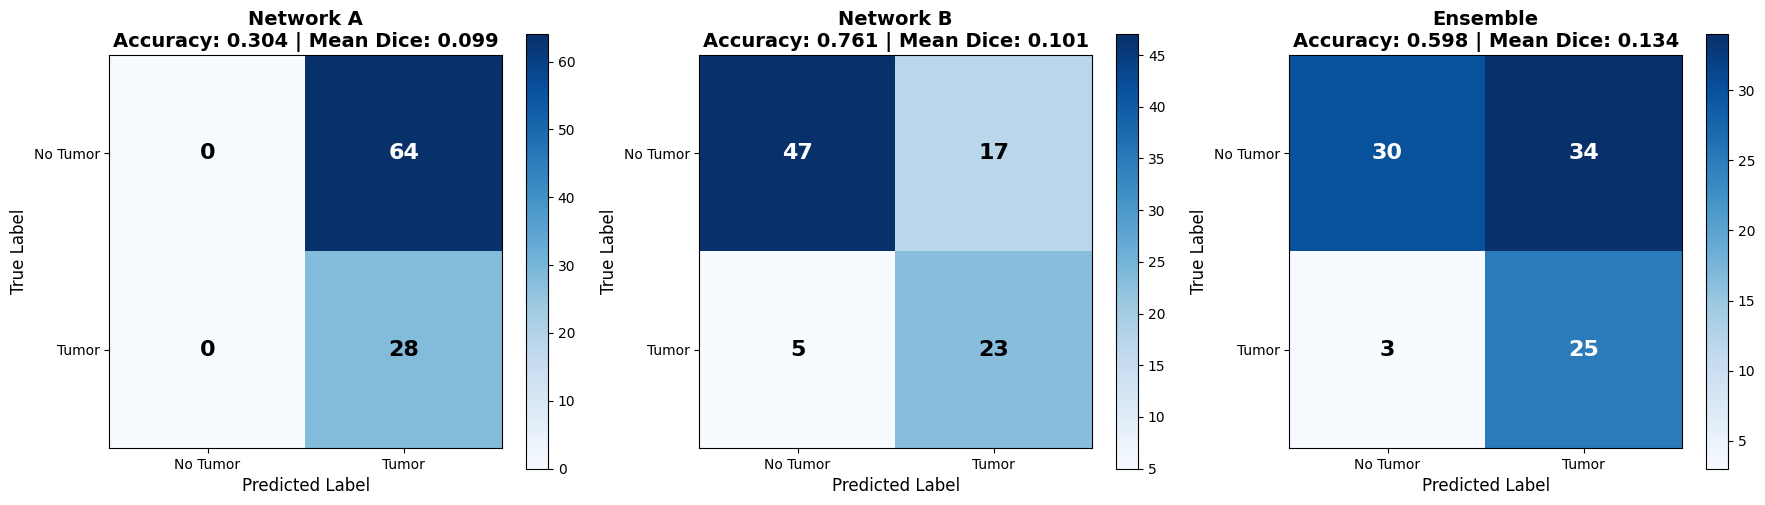

In [10]:
def classify_from_mask(mask_pred, mask_true, threshold=0.5, epsilon=1e-7):
    """
    Classify image based on segmentation probabilities [0, 1].
    
    Classification logic:
    - If ANY pixel >= threshold (0.5) in predicted mask → Tumor (1)
    - If NO pixels >= threshold → Healthy (0)
    
    Also computes Dice and IoU metrics for analysis.
    
    Args:
        mask_pred: Predicted segmentation probabilities [0, 1] (after sigmoid)
        mask_true: Ground truth mask [0, 1]
        threshold: Threshold for binarizing masks (default 0.5)
        epsilon: Small constant for numerical stability
    
    Returns:
        predicted_class: 1 if any tumor pixel detected, 0 otherwise
        dice_score: Dice coefficient for this prediction
        iou_score: IoU for this prediction
    """
    # Binarize masks at threshold 0.5
    # mask_pred already contains probabilities [0,1] from sigmoid
    # Pixels with prob ≥ 0.5 become 1, pixels < 0.5 become 0
    pred_binary = (mask_pred > threshold).float()
    true_binary = (mask_true > threshold).float()
    
    # Compute Dice coefficient
    intersection = (pred_binary * true_binary).sum().item()
    pred_sum = pred_binary.sum().item()  # Count of pixels with value 1
    true_sum = true_binary.sum().item()
    
    dice = (2.0 * intersection) / (pred_sum + true_sum + epsilon)
    
    # Compute IoU
    union = pred_sum + true_sum - intersection
    iou = intersection / (union + epsilon)
    
    # Classification: If ANY pixel == 1 (after thresholding) → Tumor
    # If ALL pixels == 0 → Healthy
    predicted_class = 1 if pred_sum > 0 else 0
    
    return predicted_class, dice, iou


def evaluate_segmentation_and_classification(trainer, dataloader, split_name="Test"):
    """
    Evaluate both segmentation and classification.
    Classification is derived from segmentation quality (Dice/IoU scores).
    
    Returns metrics for:
    - Network A (individual)
    - Network B (individual)
    - Ensemble (A + B averaged)
    """
    trainer.unet_a.eval()
    trainer.unet_b.eval()
    
    # Collect predictions
    all_seg_preds_a, all_seg_preds_b, all_seg_preds_ensemble = [], [], []
    all_seg_true = []
    all_clf_preds_a, all_clf_preds_b, all_clf_preds_ensemble = [], [], []
    all_clf_true = []
    
    # Per-sample metrics for analysis
    all_dice_scores_a, all_dice_scores_b, all_dice_scores_ensemble = [], [], []
    all_iou_scores_a, all_iou_scores_b, all_iou_scores_ensemble = [], [], []
    
    print("\n" + "="*70)
    print(f"🔍 EVALUATING ON {split_name.upper()} SET")
    print("="*70)
    print("Classification based on: Segmentation probabilities [0, 1] from sigmoid")
    print("Metrics computed: Dice & IoU for each sample\n")
    
    with torch.no_grad():
        for images, masks, clf_labels in tqdm(dataloader, desc=f"Evaluating {split_name}"):
            images = images.to(trainer.device)
            
            # Get predictions from both networks + ensemble
            seg_ensemble, seg_a, seg_b = trainer.predict_ensemble(images)
            
            # Store segmentation predictions
            all_seg_preds_a.append(seg_a.cpu())
            all_seg_preds_b.append(seg_b.cpu())
            all_seg_preds_ensemble.append(seg_ensemble.cpu())
            all_seg_true.append(masks.cpu())
            
            # Classify from masks (for each network + ensemble)
            for i in range(seg_ensemble.size(0)):
                # Network A
                pred_label_a, dice_a, iou_a = classify_from_mask(seg_a[i].cpu(), masks[i].cpu())
                all_clf_preds_a.append(pred_label_a)
                all_dice_scores_a.append(dice_a)
                all_iou_scores_a.append(iou_a)
                
                # Network B
                pred_label_b, dice_b, iou_b = classify_from_mask(seg_b[i].cpu(), masks[i].cpu())
                all_clf_preds_b.append(pred_label_b)
                all_dice_scores_b.append(dice_b)
                all_iou_scores_b.append(iou_b)
                
                # Ensemble
                pred_label_ensemble, dice_ens, iou_ens = classify_from_mask(seg_ensemble[i].cpu(), masks[i].cpu())
                all_clf_preds_ensemble.append(pred_label_ensemble)
                all_dice_scores_ensemble.append(dice_ens)
                all_iou_scores_ensemble.append(iou_ens)
                
                true_label = clf_labels[i].item()
                all_clf_true.append(true_label)
    
    # Concatenate results
    seg_preds_a = torch.cat(all_seg_preds_a, dim=0)
    seg_preds_b = torch.cat(all_seg_preds_b, dim=0)
    seg_preds_ensemble = torch.cat(all_seg_preds_ensemble, dim=0)
    seg_true = torch.cat(all_seg_true, dim=0)
    
    # ===============================
    # SEGMENTATION METRICS
    # ===============================
    def compute_seg_metrics(pred, true, name):
        pred_binary = (pred > 0.5).float()
        true_binary = (true > 0.5).float()
        
        pred_flat = pred_binary.view(-1)
        true_flat = true_binary.view(-1)
        
        TP = (pred_flat * true_flat).sum().item()
        FP = (pred_flat * (1 - true_flat)).sum().item()
        FN = ((1 - pred_flat) * true_flat).sum().item()
        TN = ((1 - pred_flat) * (1 - true_flat)).sum().item()
        
        epsilon = 1e-7
        
        iou = TP / (TP + FP + FN + epsilon)
        dice = (2 * TP) / (2 * TP + FP + FN + epsilon)
        pixel_acc = (TP + TN) / (TP + TN + FP + FN + epsilon)
        sensitivity = TP / (TP + FN + epsilon)
        specificity = TN / (TN + FP + epsilon)
        precision = TP / (TP + FP + epsilon)
        
        # BCE Loss
        bce_loss = F.binary_cross_entropy(pred.clamp(epsilon, 1-epsilon), true).item()
        
        return {
            'name': name,
            'IoU': iou,
            'Dice': dice,
            'BCE_Loss': bce_loss,
            'Pixel_Accuracy': pixel_acc,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Precision': precision
        }
    
    seg_metrics_a = compute_seg_metrics(seg_preds_a, seg_true, "Network A")
    seg_metrics_b = compute_seg_metrics(seg_preds_b, seg_true, "Network B")
    seg_metrics_ensemble = compute_seg_metrics(seg_preds_ensemble, seg_true, "Ensemble")
    
    # Print segmentation metrics
    print("\n" + "🎯 SEGMENTATION METRICS ".center(70, "="))
    print(f"\n{'Metric':<20} {'Network A':>15} {'Network B':>15} {'Ensemble':>15}")
    print("-" * 70)
    for metric in ['Dice', 'IoU', 'BCE_Loss', 'Pixel_Accuracy', 'Sensitivity', 'Specificity', 'Precision']:
        print(f"{metric:<20} {seg_metrics_a[metric]:>15.4f} {seg_metrics_b[metric]:>15.4f} {seg_metrics_ensemble[metric]:>15.4f}")
    
    # ===============================
    # CLASSIFICATION METRICS
    # ===============================
    def compute_clf_metrics(preds, true, dice_scores, iou_scores, name):
        preds = np.array(preds)
        true = np.array(true)
        dice_scores = np.array(dice_scores)
        iou_scores = np.array(iou_scores)
        
        TP = np.sum((preds == 1) & (true == 1))
        TN = np.sum((preds == 0) & (true == 0))
        FP = np.sum((preds == 1) & (true == 0))
        FN = np.sum((preds == 0) & (true == 1))
        
        cm = np.array([[TN, FP], [FN, TP]])
        
        epsilon = 1e-7
        accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
        precision = TP / (TP + FP + epsilon)
        recall = TP / (TP + FN + epsilon)
        f1_score = 2 * (precision * recall) / (precision + recall + epsilon)
        
        # Average Dice/IoU for each classification outcome
        tp_indices = (preds == 1) & (true == 1)
        tn_indices = (preds == 0) & (true == 0)
        fp_indices = (preds == 1) & (true == 0)
        fn_indices = (preds == 0) & (true == 1)
        
        avg_dice_tp = dice_scores[tp_indices].mean() if tp_indices.sum() > 0 else 0
        avg_dice_tn = dice_scores[tn_indices].mean() if tn_indices.sum() > 0 else 0
        avg_dice_fp = dice_scores[fp_indices].mean() if fp_indices.sum() > 0 else 0
        avg_dice_fn = dice_scores[fn_indices].mean() if fn_indices.sum() > 0 else 0
        
        return {
            'name': name,
            'Confusion_Matrix': cm,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1_Score': f1_score,
            'Mean_Dice': dice_scores.mean(),
            'Mean_IoU': iou_scores.mean(),
            'Avg_Dice_TP': avg_dice_tp,
            'Avg_Dice_TN': avg_dice_tn,
            'Avg_Dice_FP': avg_dice_fp,
            'Avg_Dice_FN': avg_dice_fn
        }
    
    clf_metrics_a = compute_clf_metrics(all_clf_preds_a, all_clf_true, all_dice_scores_a, all_iou_scores_a, "Network A")
    clf_metrics_b = compute_clf_metrics(all_clf_preds_b, all_clf_true, all_dice_scores_b, all_iou_scores_b, "Network B")
    clf_metrics_ensemble = compute_clf_metrics(all_clf_preds_ensemble, all_clf_true, all_dice_scores_ensemble, all_iou_scores_ensemble, "Ensemble")
    
    # Print classification metrics
    print("\n" + "🎯 CLASSIFICATION METRICS (from Seg Probs [0,1]) ".center(70, "="))
    print(f"\n{'Metric':<20} {'Network A':>15} {'Network B':>15} {'Ensemble':>15}")
    print("-" * 70)
    for metric in ['Accuracy', 'Precision', 'Recall', 'F1_Score']:
        print(f"{metric:<20} {clf_metrics_a[metric]:>15.4f} {clf_metrics_b[metric]:>15.4f} {clf_metrics_ensemble[metric]:>15.4f}")
    
    print("\nPer-Sample Metrics:")
    print(f"{'Mean Dice':<20} {clf_metrics_a['Mean_Dice']:>15.4f} {clf_metrics_b['Mean_Dice']:>15.4f} {clf_metrics_ensemble['Mean_Dice']:>15.4f}")
    print(f"{'Mean IoU':<20} {clf_metrics_a['Mean_IoU']:>15.4f} {clf_metrics_b['Mean_IoU']:>15.4f} {clf_metrics_ensemble['Mean_IoU']:>15.4f}")
    
    # Plot Confusion Matrices
    print("\n" + "📊 CONFUSION MATRICES ".center(70, "="))
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, (metrics, ax) in enumerate(zip([clf_metrics_a, clf_metrics_b, clf_metrics_ensemble], axes)):
        cm = metrics['Confusion_Matrix']
        im = ax.imshow(cm, cmap='Blues', interpolation='nearest')
        plt.colorbar(im, ax=ax)
        
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['No Tumor', 'Tumor'])
        ax.set_yticklabels(['No Tumor', 'Tumor'])
        
        for i in range(2):
            for j in range(2):
                ax.text(j, i, int(cm[i, j]),
                       ha="center", va="center",
                       color="white" if cm[i, j] > cm.max()/2 else "black",
                       fontsize=16, fontweight='bold')
        
        ax.set_title(f"{metrics['name']}\nAccuracy: {metrics['Accuracy']:.3f} | Mean Dice: {metrics['Mean_Dice']:.3f}", 
                    fontsize=14, fontweight='bold')
        ax.set_ylabel('True Label', fontsize=12)
        ax.set_xlabel('Predicted Label', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70 + "\n")
    
    return {
        'segmentation': {
            'network_a': seg_metrics_a,
            'network_b': seg_metrics_b,
            'ensemble': seg_metrics_ensemble
        },
        'classification': {
            'network_a': clf_metrics_a,
            'network_b': clf_metrics_b,
            'ensemble': clf_metrics_ensemble
        }
    }


# Evaluate on Test Set
test_results = evaluate_segmentation_and_classification(
    codeepnet_trainer, test_loader, split_name="Test"
)